In [1]:
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.bag as db
import tqdm 

from distributed import Client
from dask_jobqueue import SLURMCluster
from IPython.display import display

import os
from glob import glob

In [2]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='256GB', cores=8, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

Client Scheduler: tcp://127.0.0.1:45061 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 4.29 GB


In [3]:
train_df = pd.read_csv("train_df_full.csv")
print(train_df.shape)

(17663162, 5)


In [4]:
val_df = pd.read_csv("val_df_full.csv")
print(val_df.shape)

(4525759, 5)


# Baseline Model

Compute the mean rating of each movie by grouping by movieId, and aggregating by mean. Note that we don't want to explicitly compute the utility matrix, because doing so will take a very long time, and the resulting matrix will be very large and take up a lot of memory.

We compute the 100 highest mean-rated movies from the training set. We will recommend these 100 movies to every single user in the validation set.

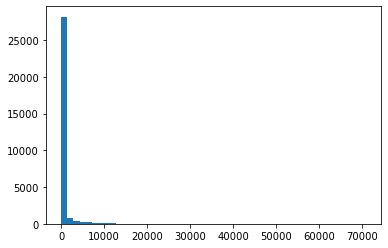

In [5]:
plt.hist(train_df.groupby('movieId').count()['userId'], bins=50)
plt.show()

In [6]:
# Compute mean ratings
mean_ratings = train_df[["movieId", "rating"]].groupby("movieId").mean()["rating"].sort_values(ascending=False)

# We need to recommend to everyone in the validation set the 100 movies that we learned from the training set
R_i = np.array(mean_ratings.head(100).index)
print(R_i)

[155575 180453  95765 185081 151601  86766 166790 160694 174419 174473
 182871  86862 136962 171071 158823 176813 187957  99724 191359 187611
 171289 134615 166217  94471 169352 169370 158970  84983 143791   6501
  62206 135510  95517 137797  86318 179369 179357 139871 163767 117580
 146252 142871 178615 169970 182549 184573 167696 184855 133667  88886
 149709 175455 122484 170205 167608 167526 161802  89620 161796 178771
 157112 132902  98834 149348 181475  99260 169812 190957 162866 122084
 161094 149426  98699 167984  87923  71047  90464 113039 182551  79022
   6106  60229 102961  56102 186125 165671 165737  79842 165153 177601
 192559 153937 183339 168828 144712 152192 180443 192293 183907 136648]


## Recommendation Algorithm

In [7]:
# Number of users in the validation data
users = val_df['userId'].unique()
n_users = len(users)

# Number of movies that we recommend to each user
n_recs = 100

# Initialize array of relevances
rel_D = pd.DataFrame(np.empty(shape=(n_users, n_recs)), index=users, columns=R_i)

For faster computation, we'd like to create a list of arrays `D`, where each element of the list (`D[i]`) is an array containing the validation data of the highest-rated movies by this user (from highest to lowest rating). But to do this, we need to sort the entire validation data from highest to lowest rating, so that `.get_group` will return a movies array sorted from highest to lowest rating as well.

In [8]:
%%time
val_df = val_df.sort_values("rating", ascending=False)
val_df_group = val_df.groupby("userId")
D = list(map(lambda user: val_df_group.get_group(user)["movieId"].values[0:100], users))

# For each user, compute relevance
# rel_D[u, m] = 1 if recommended movie m is relevant to user u and 0 otherwise
rel_D[:] = np.row_stack(list(map(lambda D_i: np.isin(R_i, D_i).astype(int), D)))
rel_D

CPU times: user 46.9 s, sys: 776 ms, total: 47.7 s
Wall time: 48.4 s


,155575,180453,95765,185081,151601,86766,166790,160694,174419,174473,...,192559,153937,183339,168828,144712,152192,180443,192293,183907,136648
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
%%time
# Compute precision at k=100
k = 100
precision = np.mean(np.sum(rel_D, axis=1) / k)
print("Precision: {}%".format(np.round(precision*100, 5)))

Precision: 0.00084%
CPU times: user 23.4 ms, sys: 976 µs, total: 24.4 ms
Wall time: 28.2 ms


In [10]:
%%time
# Compute MAP
j_plus_1 = np.arange(1, 101)
inner_sum = np.sum(rel_D / j_plus_1, axis=1)
N = np.fromiter(map(lambda D_i: D_i.size, D), dtype=int) # an array where N[i] = number of movies rated by user i
MAP = np.mean(1/N * inner_sum)
print("The MAP is: {}%".format(np.round(MAP*100, 5)))

The MAP is: 8e-05%
CPU times: user 159 ms, sys: 58.4 ms, total: 218 ms
Wall time: 224 ms


### Questions

* Should we be constructing our baseline model using the whole dataset or only the training set?

### Comments
* Is it ok to use training set + validation set to train our baseline model? Would the scores be comparable to the more advanced model, which we train only on the training set?

### To-Do
* Currently we only keep movies with at least 5 ratings - we should probably change this number depending on the size of the dataset